# Computer Vision III: Detection, Segmentation and Tracking (CV3DST) (IN2375) Exercise

In this exercise we provide you with a baseline multi-object tracker on the [MOT16](https://motchallenge.net/data/MOT16/) dataset. Your task is to improve its tracking performance by applying different techniques from the lecture. As most modern multi-object trackers, the provided baseline follows the tracking-by-detection paradigm. To this end, an object detector is applied to each frame indepdently and in a subsequent data association step the detections are combined to tracks over multiple frames. The challenge is to connect the correct detections of the same object and produce identity preserving tracks.

The improvement on the provided baseline tracker can be achieved in multiple ways:

*   Improving the object detector.
*   Improving the tracker (data association step).
*   Incorporating segmentation information.



## Setup

### Download and extract project data to your Google Drive

1.   Install Google Drive on your desktop.
2.   Save this notebook to your Google Drive by clicking `Save a copy in Drive` from the `File` menu.
3.   Download [this](https://vision.in.tum.de/webshare/u/meinhard/cv3dst_exercise.zip) zip file to your desktop and extract it into the `Colab Notebooks` folder in your Google Drive.
4.   Wait until Google Drive finished the synchronisation. (This might take a while.)


#### Connect the notebook to your Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
root_dir = "gdrive/My Drive/Colab Notebooks/cv3dst_exercise"

The `root_dir` path points to the directory and the content in your Google Drive.

In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/src/tracker"

data  models  output  src
customs.py	    data_track.py  object_detector.py  tracker.py
data_obj_detect.py  __init__.py    __pycache__	       utils.py


#### Install and import Python libraries

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(root_dir, 'src'))

!pip install tqdm lap
!pip install https://github.com/timmeinhardt/py-motmetrics/archive/fix_pandas_deprecating_warnings.zip

     |████████████████████████████████| 1.5MB 4.8MB/s 
  Created wheel for lap: filename=lap-0.4.0-cp36-cp36m-linux_x86_64.whl size=1589006 sha256=23db680c810b1837405904eac1b57c601676e56c726b0a7d67fd2196997e0339
  Stored in directory: /root/.cache/pip/wheels/da/3e/af/eddcd6ffaa27df8d0ddac573758f8953c4e57c64c4c8c8b7d0
Successfully built lap
     - 419kB 6.4MB/s
  Created wheel for motmetrics: filename=motmetrics-1.1.3-cp36-none-any.whl size=134190 sha256=efd4a7f53b8c4cc1ad80ff270cbfcd27d4c2dd6cf72864ea9790498489c3d243
  Stored in directory: /tmp/pip-ephem-wheel-cache-pscg9xhg/wheels/c9/e9/0a/79599df270874df0ab21a57a729e8a956aed3c744da3397efc
Successfully built motmetrics


In [ ]:
!pip install motmetrics

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm
import sys
root_dir = "/content/gdrive/My Drive/Colab Notebooks/cv3dst_exercise"
sys.path.append(root_dir + "/src")
sys.path.append(root_dir)

import torch
from torch.utils.data import DataLoader
from models.reid.resnet import resnet50
from tracker.data_track import MOT16Sequences
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN
from tracker.tracker import Tracker
from tracker.utils import (plot_sequence, evaluate_mot_accums, get_mot_accum,
                           evaluate_obj_detect, obj_detect_transforms)
from torch.jit.annotations import Optional, List, Dict, Tuple
import motmetrics as mm
mm.lap.default_solver = 'lap'
from tracker.customs import TrackerIoUAssignment,Tracktor, Tracktor_plus
from torchvision.models.detection.image_list import ImageList
import torch.nn.functional as F
import resource
soft, hard = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (hard, hard))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


# MOT16 dataset

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation.

The `MOT17Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'mot16_02'`, or the entire train/test set, e.g., `seq_name = 'mot16_train'`.

At this point the test set directort is still empty. Later in the semester we will provide you with the necesssary test sequences to submit to our challenge.

In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/test"

MOT16-02  MOT16-04  MOT16-05  MOT16-09	MOT16-10  MOT16-11  MOT16-13
MOT16-01  MOT16-03  MOT16-08  MOT16-12


In order to compare the tracking performance of different trackers without the effect of the object detector, the MOTChallenge provides a precomputed set of public object detections. Trackers are then evaluated on their capabilities to form tracks with the provided set. However, we want to allow you to improve on the object detections as well. Therefore, we participate in the MOT16 challenge with private detections.

## Instance segmentations

We provide the instance segmentations for the sequences `02`, `05`, `09` and `11`. These can be used for example to train a method which improves the bounding box position in occluded situations. See the original MOTS [webpage](https://www.vision.rwth-aachen.de/page/mots) for more info.

In [ ]:
# seq_name = 'MOT16-02'
# data_dir = os.path.join(root_dir, 'data/MOT16')
# sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)

# for seq in sequences:
#     for i, frame in enumerate(seq):
#         img = frame['img']
        
#         dpi = 96
#         fig, ax = plt.subplots(1, dpi=dpi)

#         img = img.mul(255).permute(1, 2, 0).byte().numpy()
#         width, height, _ = img.shape
          
#         ax.imshow(img, cmap='gray')
#         fig.set_size_inches(width / dpi, height / dpi)

#         if 'gt' in frame:
#             gt = frame['gt']
#             for gt_id, box in gt.items():
#                 rect = plt.Rectangle(
#                   (box[0], box[1]),
#                   box[2] - box[0],
#                   box[3] - box[1],
#                   fill=False,
#                   linewidth=1.0)
#                 ax.add_patch(rect)

#         plt.axis('off')
#         plt.show()

#         if 'seg_img' in frame:
#             seg_img = frame['seg_img']
#             fig, ax = plt.subplots(1, dpi=dpi)
#             fig.set_size_inches(width / dpi, height / dpi)
#             ax.imshow(seg_img, cmap='Greens')
#             plt.axis('off')
#             plt.show()
#         break

# Object detector

We provide you with an object detector pretrained on the MOT challenge training set. This detector can be used and improved to generate the framewise detections necessary for the subsequent tracking and data association step.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/models"

faster_rcnn_fpn.model  model_epoch_27.model  reid  ResNet_iter_25245.pth



## Configuration

If you uncomment und run the following evaluation of the object detection training set, you should obtain the following evaluation result:

`AP: 0.8677356206210984 Prec: 0.9220907182151947 Rec: 0.9167998134001982 TP: 78611.0 FP: 6642.0`

## Setup

## Run tracker

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm
import sys
root_dir = "gdrive/My Drive/Colab Notebooks/cv3dst_exercise"
sys.path.append(root_dir + "/src")
sys.path.append(root_dir)

import torch
from torch.utils.data import DataLoader
from models.reid.resnet import resnet50
from tracker.data_track import MOT16Sequences
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN
from tracker.tracker import Tracker
from tracker.utils import (plot_sequence, evaluate_mot_accums, get_mot_accum,
                           evaluate_obj_detect, obj_detect_transforms)
from torch.jit.annotations import Optional, List, Dict, Tuple
import motmetrics as mm
mm.lap.default_solver = 'lap'
from tracker.customs import TrackerIoUAssignment,Tracktor, Tracktor_plus
from torchvision.models.detection.image_list import ImageList
import torch.nn.functional as F
import resource
soft, hard = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (hard, hard))



data_dir = os.path.join(root_dir, 'data/MOT16')
seqname = "MOT16-train"
print("Loading sequences")
t=time.time()

sequences = MOT16Sequences(seqname,data_dir, load_seg=True)
print("Loaded in ",time.time() -t)
obj_detect_model_file = os.path.join(root_dir, 'models/faster_rcnn_fpn.model')
print("old model")

obj_detect_nms_thresh = 0.3
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,
                                   map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect.to(device)


seed = 12345
data_dir = os.path.join(root_dir, 'data/MOT16')
output_dir = os.path.join(root_dir, 'output')

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# dataset


Loading sequences
Loaded in  1009.270838022232
old model


In [ ]:

reid ={'cnn': {'output_dim': 128}, 'dataloader': {'K': 4, 'P': 18, 'crop_H': 256, 'crop_W': 128, 'max_per_person': 1000, 'normalize_mean': [0.485, 0.456, 0.406], 'normalize_std': [0.229, 0.224, 0.225], 'transform': 'random', 'vis_threshold': 0.3}, 'db_train': 'train', 'db_val': False, 'desription': 'all', 'lr_scheduler': True, 'max_epochs': 69, 'model_args': {'loss': 'batch_hard', 'margin': 0.2, 'prec_at_k': 3}, 'module_name': 'reid', 'name': 'res50-mot17-batch_hard', 'seed': 12345, 'solver': {'optim': 'Adam', 'optim_args': {'lr': 0.0003, 'weight_decay': 0.0}}}
reid_network = resnet50(pretrained=False, **reid['cnn'])
reid_network.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/cv3dst_exercise/models/ResNet_iter_25245.pth",
                                        map_location=lambda storage, loc: storage))
reid_network.eval()
reid_network.cuda()

# tracker = Tracktor(obj_detect)

time_total = 0
mot_accums = []
results_seq = {}
max_frames = 2
l_active = 0.6 # gives stability because less active tracks are killed
s_active = 0.5
l_new = 0.2
all_results = []
idx = 0
for seq in sequences:
    tracker = Tracktor_plus(obj_detect,reid_network)
    if idx == 0:
      print(tracker.reid_sim_threshold)
    now = time.time()
    tracker.init_thresholds(l_active,s_active,l_new)
    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        # idx+=1
        # if idx > max_frames:
        #   break
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        print("accumulatin")
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))
    evaluate_mot_accums([get_mot_accum(results, seq)],[str(seq)],generate_overall=False)    
    print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

0.5
2.5
Tracking: MOT16-02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



accumulatin
Tracks found: 131
Runtime for MOT16-02: 571.9 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-02.txt
          IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML FP    FN IDs  FM  MOTA  MOTP
MOT16-02 41.0% 68.6% 29.3% 42.4% 99.4% 62  9 34 19 44 10708 110  86 41.5% 0.078
Runtime for all sequences: 571.9 s.
0.5
2.5
Tracking: MOT16-04


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



accumulatin
Tracks found: 208
Runtime for MOT16-04: 1803.5 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-04.txt
          IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML  FP    FN IDs  FM  MOTA  MOTP
MOT16-04 69.4% 80.3% 61.1% 75.8% 99.5% 83 42 27 14 178 11528 138  94 75.1% 0.102
Runtime for all sequences: 2375.4 s.
0.5
2.5
Tracking: MOT16-13


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



accumulatin
Tracks found: 200
Runtime for MOT16-13: 1194.4 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-13.txt
          IDF1   IDP   IDR  Rcll  Prcn  GT MT PT ML  FP   FN IDs  FM  MOTA  MOTP
MOT16-13 56.2% 73.0% 45.7% 61.8% 98.6% 110 45 40 25 103 4452 132  83 59.7% 0.127
Runtime for all sequences: 3569.7 s.
0.5
2.5
Tracking: MOT16-09


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



accumulatin
Tracks found: 67
Runtime for MOT16-09: 636.5 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-09.txt
          IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML FP   FN IDs  FM  MOTA  MOTP
MOT16-09 55.0% 70.4% 45.2% 63.2% 98.4% 26 13 11  2 54 1962  48  37 61.2% 0.081
Runtime for all sequences: 4206.3 s.
0.5
2.5
Tracking: MOT16-11


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



accumulatin
Tracks found: 111
Runtime for MOT16-11: 1321.2 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-11.txt
          IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML FP   FN IDs  FM  MOTA  MOTP
MOT16-11 65.7% 75.8% 58.0% 75.8% 99.0% 75 35 25 15 69 2288  58  42 74.4% 0.080
Runtime for all sequences: 5527.5 s.
0.5
2.5
Tracking: MOT16-10


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



accumulatin
Tracks found: 135
Runtime for MOT16-10: 955.4 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-10.txt
          IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML  FP   FN IDs   FM  MOTA  MOTP
MOT16-10 54.7% 68.1% 45.7% 65.8% 98.1% 57 23 25  9 167 4393 101  127 63.7% 0.140
Runtime for all sequences: 6482.9 s.
0.5
2.5
Tracking: MOT16-05


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



accumulatin
Tracks found: 221
Runtime for MOT16-05: 612.4 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-05.txt
          IDF1   IDP   IDR  Rcll  Prcn  GT MT PT ML FP   FN IDs   FM  MOTA  MOTP
MOT16-05 59.5% 75.1% 49.2% 64.2% 97.9% 133 44 72 17 93 2477 149  104 60.7% 0.138
Runtime for all sequences: 7095.3 s.
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT  ML  FP    FN IDs   FM  MOTA  MOTP
MOT16-02 41.0% 68.6% 29.3% 42.4% 99.4%  62   9  34  19  44 10708 110   86 41.5% 0.078
MOT16-04 69.4% 80.3% 61.1% 75.8% 99.5%  83  42  27  14 178 11528 138   94 75.1% 0.102
MOT16-13 56.2% 73.0% 45.7% 61.8% 98.6% 110  45  40  25 103  4452 132   83 59.7% 0.127
MOT16-09 55.0% 70.4% 45.2% 63.2% 98.4%  26  13  11   2  54  1962  48   37 61.2% 0.081
MOT16-11 65.7% 75.8% 58.0% 75.8% 99.0%  75  35  25  15  69  2288  58   42 74.4% 0.080
MOT16-10 54.7% 68.1% 45.7% 65.8% 98.1%  57  23  25   9 167  4393 101  127 63.7% 0.140
MOT16-05 59.5% 75.1% 49.2% 64.2% 97.9% 133  4

In [ ]:
evaluate_mot_accums([get_mot_accum(results, seq)],[str(seq)],generate_overall=False)

NameError: ignored

The current state-of-the-art multi-object tracker [Tracktor++](https://arxiv.org/abs/1903.05625) achieves the following tracking results on the `MOT16-train` sequences:

              IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT  ML  FP    FN IDs   FM  MOTA  MOTP
    MOT17-02 45.8% 78.3% 32.4% 41.3% 99.8%  62   9  32  21  18 10909  59   68 40.9% 0.080
    MOT17-04 71.1% 90.3% 58.6% 64.7% 99.8%  83  32  29  22  71 16785  22   29 64.5% 0.096
    MOT17-05 64.0% 86.6% 50.7% 57.5% 98.1% 133  32  65  36  75  2942  37   59 55.8% 0.144
    MOT17-09 54.6% 69.4% 45.0% 64.3% 99.1%  26  11  13   2  31  1903  22   31 63.3% 0.086
    MOT17-10 64.3% 75.7% 55.9% 72.4% 98.0%  57  28  26   3 189  3543  71  125 70.4% 0.148
    MOT17-11 63.3% 77.0% 53.7% 69.0% 98.9%  75  24  33  18  73  2924  26   26 68.0% 0.081
    MOT17-13 73.6% 85.1% 64.8% 74.2% 97.6% 110  60  39  11 213  3000  62   90 71.9% 0.132
    OVERALL  65.0% 84.0% 53.1% 62.6% 99.1% 546 196 237 113 670 42006 299  428 61.7% 0.106

For your final submission you should focus on improving `MOTA`.

## Visualize tracking results

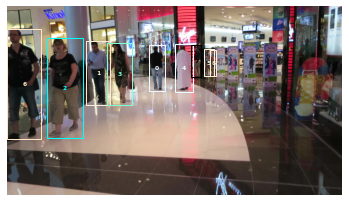

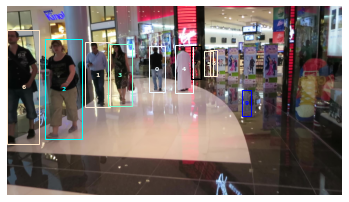

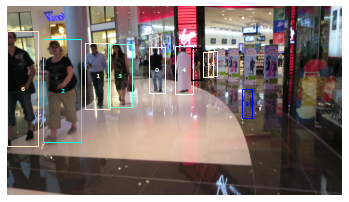

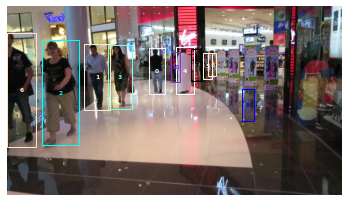

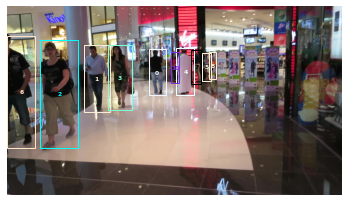

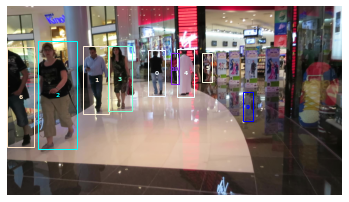

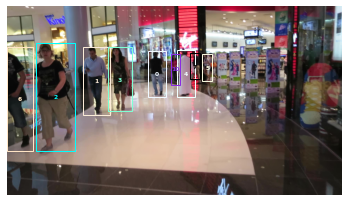

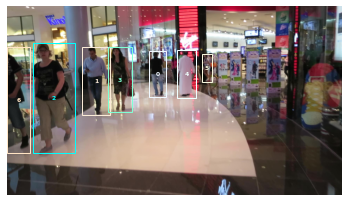

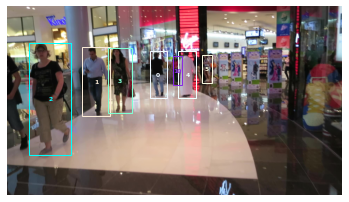

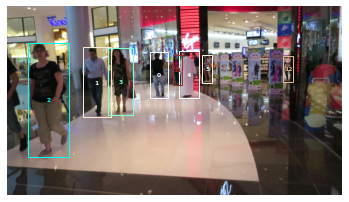

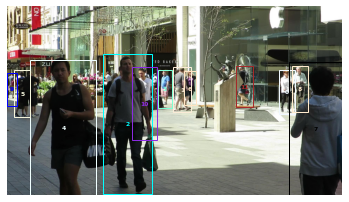

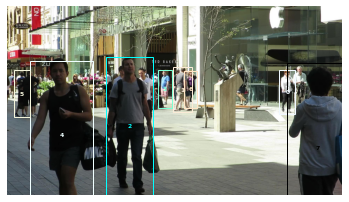

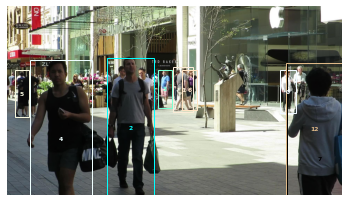

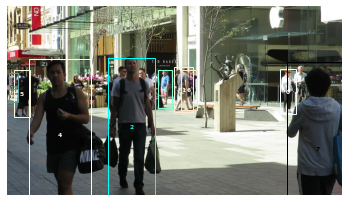

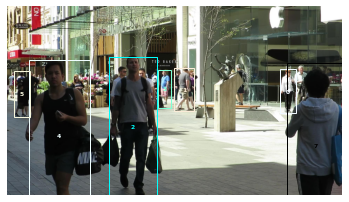

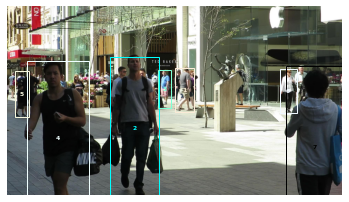

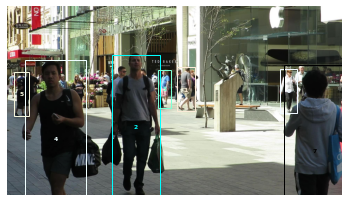

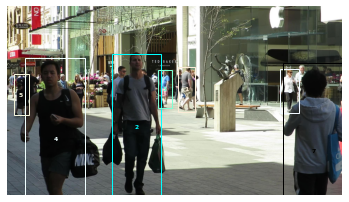

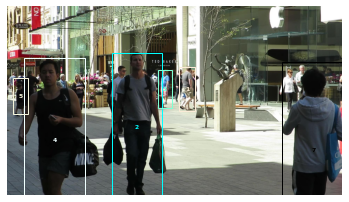

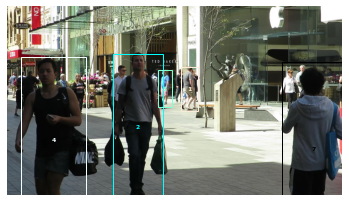

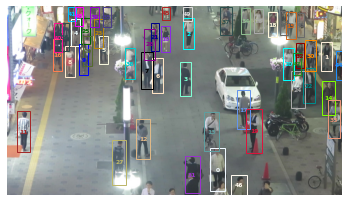

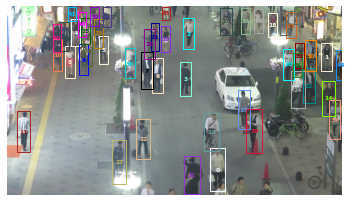

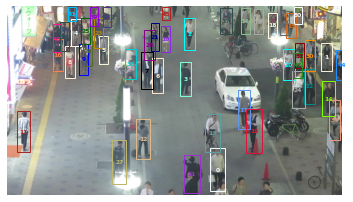

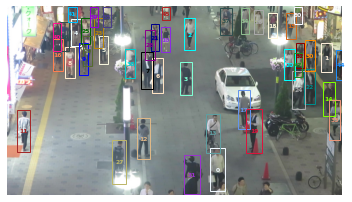

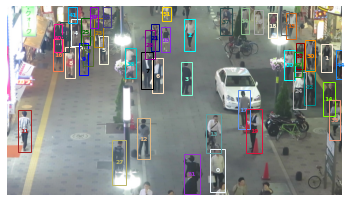

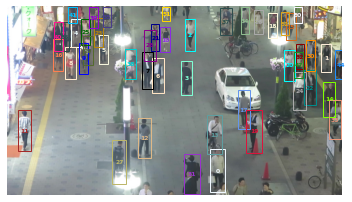

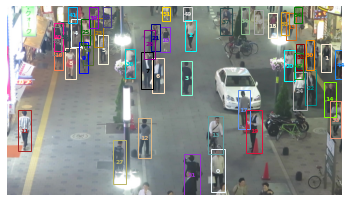

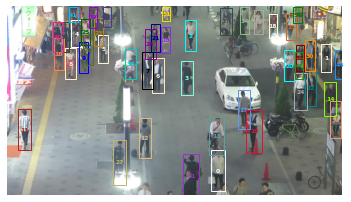

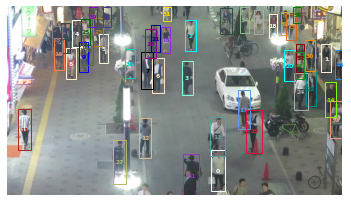

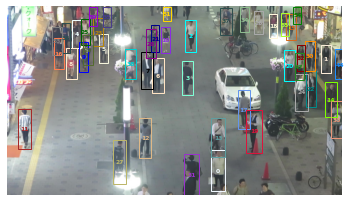

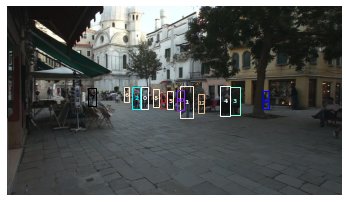

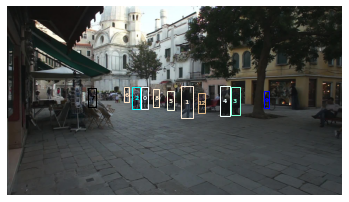

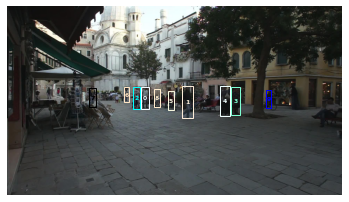

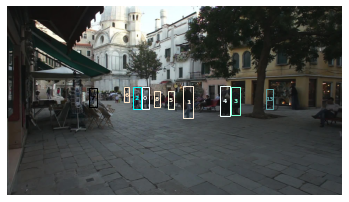

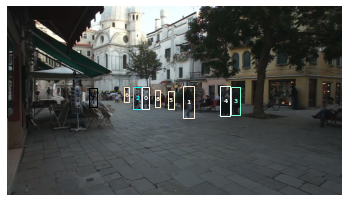

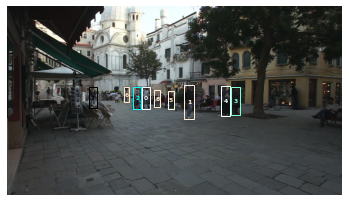

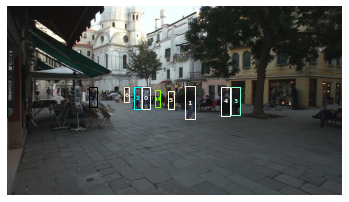

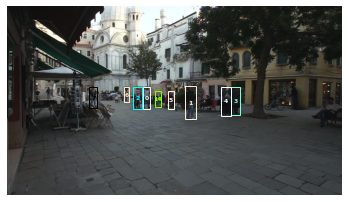

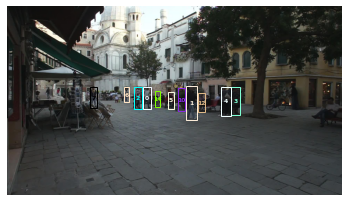

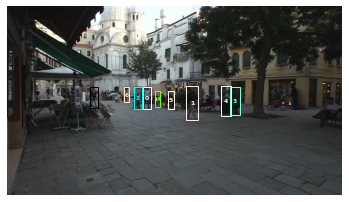

In [ ]:

for seq in sequences:
  plot_sequence(results_seq[str(seq)],
              [s for s in sequences if str(s) == str(seq)][0],
              first_n_frames=10)

# Notes and next steps

*   Experiment and debug on a single train sequence. If something works on a single sequence evaluate all train sequences to check the generaliztion of your improvement.
*   Remember to split the training set into multiple sets with different sequences if you train something and want to avoid overfitting.
*   Sometimes the execution of a cell gets stuck. If this happends just abort the execution and restart the cell.
*   If the notebook warns you that currently no GPU hardware acceleration is available, try again later and focus on some debugging or experiments than can be done only with the CPU.
* Try to improve your results on your local train/validation splits before submitting to our test servers. The submission will be limited to avoid overfitting to the test sequences.


# Exercise submission

The `seq.write_results(results, os.path.join(output_dir))` statement saves predicted tracks into files. After executing this notebook the `output` directory in your Google Drive should contain multiple `MOT16-XY.txt` files.

For the final submission you have to process the test sequences and upload the zipped prediction files to our server. More information on this will follow.

We will make the test sequences and minimum `MOTA` for receiving the exam bonus available by the end of december.

In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/"